### Исследование пользователей сервиса аренды самокатов GoFast

#### Введение

У нас есть данные о пользовании арендой самокатов GoFast. Исследуем данные и сравним две группы пользователей - тех, кто пользуется платной подпиской и нет. 

Сначала проведем первичную обработку данных, посмотрим на основные параметры поездки - дистанцию, время, распрделение пользователей по городам.

Далее проверим несколько гипотез:
1. проверим, различается ли длительность поездки у пользователей с подпиской и без. 
2. посмотрим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
3. также посмотрим на среднее расстояние одной поездки среди пользователей с подпиской.

Проверка гипотез поможет определить, "выгодны" ли компании пользователи с платной подпиской. Если это так, посмотрим, что нужно сделать для привлечения большего количества пользователей, готовых платить за полписку, какие параметры рассылок и промоакций будут эффективными.

#### Шаг 1. Загрузка данных

У нас есть три файла с данными о пользовании самокатами GoFast. Откроем каждый файл и сохраним в отдельные переменнные, изучим общую информацию о каждом файле.

##### Пользователи

Создадим датафрейм 'users' с данными о пользователях сервиса.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import factorial
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users_go.csv', sep=',')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В базе данных содержится информация о 1565 пользователях сервиса аренды самокатов. Их уникальный идентификатор пользователя (user_id), имя, возраст, город и тип подписки (без подписки (free) или с подпиской (ultra)). Пропущенных значений в базе данных нет.

##### Поездки

Создадим датафрейм 'rides' с данными о поездках пользователей сервиса аренды самокатов.

In [4]:
rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В данных содержится информация о 18068 поездках пользователей сервиса аренды самокатов: уникальный идентификатор пользователя (user_id), данные о расстоянии, которое пользователь проехал в текущей поездке, ее длительность и  дата поездки. Пропущенных значений в базе данных нет.

##### Подписки

Создадим датафрейм 'subscriptions' с данными о подписках разного типа.

In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Эта небольшая база данных с двумя строками содержит информацию о характеристиках тарифов без подписки и с подпиской Ultra. В ней указана стоимость одной минуты поездки, стоимость старта (начала поездки) и стоимость абонентской платы. Пропущенных значений в базе данных нет.

При первом взгляде на данне мы выяснили, что три базы имеют разное количество наблюдений. Самая маленькая база - база с данными о полписках. Самая большая - база с данными о совершенных поездках - на каждого пользователя может приходится более одной поездки.
Данные о пользователях и о совершенных ими поездках можно соединить, используя общий столбец с user_id. К данным о пользователях можно добавить информацию о подписке, которая сейчас у них - по столбцу с данными subscription_type.
Три базы данных не содержат пропущенных значений.

#### Шаг 2. Предобработка данных

##### Изменение типа данных

В предыдущем пункте посмотрели общую инфориацию о данных. Можно заметить, что не все переменные имеют подходящий тип. Например, переменная date из базы про поездки записана как строковая переменная. Исправим ее тип на тип "дата".

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format= '%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Согласно таблице info о базе данных, тип перменной изменился на тот, который нужен. 

##### Добавим новые столбцы

Создадим новый столбец в базе данных о поездках, куда запишем номер месяца на основе столбца 'date'. 

In [9]:
rides['date_month'] = pd.DatetimeIndex(rides['date']).month

Создадим новый столбец в базе данных о поездках, куда запишем год на основе столбца 'date'.

In [10]:
rides['date_year'] = pd.DatetimeIndex(rides['date']).year

##### Временные рамки исследования

Посмотрим, за какой период есть данные в базе. Данные касаются только 2021 года, с января по декабрь.

Text(0.5, 0, 'порядковый номер месяца')

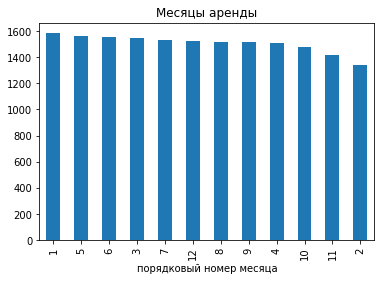

In [11]:
rides['date_year'].value_counts()
rides.groupby('date_month')['date_month'].count().sort_values(ascending=False).plot(kind='bar', title = 'Месяцы аренды')
plt.xlabel("порядковый номер месяца")

##### Пропущенные значения и дубликаты

В предыдущем разделе выяснили, что пропущенных значений в трех базах данных нет. Проверим наличие в них явных дубликатов.

In [12]:
print(users.duplicated().sum())
print(rides.duplicated().sum())
print(subscriptions.duplicated().sum())

31
0
0


В базе пользователей есть 31 полностью продублированная строчка. Удалим дубликаты.

In [13]:
users = users.drop_duplicates(keep='first')
users['user_id'].value_counts().sort_values()

1       1
5       1
6       1
7       1
8       1
       ..
1532    1
1533    1
1524    1
1525    1
1534    1
Name: user_id, Length: 1534, dtype: int64

Дубликаты удалены, уникальные идентификаторы пользователей не повторяются.

##### Вывод

Проведена первичная обработка данных. 
В одной переменной был исправлен тип данных на более подходящий - на тип "дата". 
Также были удалены задублированные строчки.
Пропущенных значений в базе не оказалось.
Добавлены новые столбцы отдельно с месяцем, отдельно - с годом поездки на самокате.

#### Шаг 3. Исследовательский анализ данных

Рассмотрим подробнее каждый показатель.

##### Города

Посмотрим распределение пользователей аренды самокатов по городам.

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

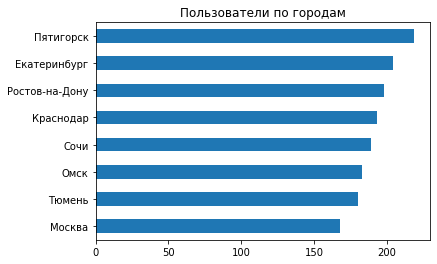

In [14]:
users.groupby('city')['city'].count().sort_values(ascending=True).plot(kind='barh', title = 'Пользователи по городам')
plt.ylabel("")
users.groupby('city')['city'].count().sort_values(ascending=False)

В каждом городе почти одинаковое количество пользователей аренды самокатов - от 168 до 219. Больше всего - в Пятигорске (219), меньше всего - в Москве (168).

##### Пользователи с подпиской / без подписки

Пользователей, которые не пользуются подпиской, немного больше - 54% против 46% пользователей с подпиской Ultra (или 835 человека против 699).

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

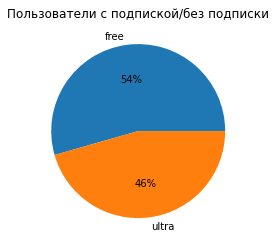

In [15]:
users.groupby('subscription_type')['subscription_type'].count().sort_values(ascending=False).plot(kind='pie', autopct='%1.0f%%', title = 'Пользователи с подпиской/без подписки')
plt.ylabel("")
users.groupby('subscription_type')['subscription_type'].count().sort_values(ascending=False)

##### Возраст пользователей

Средний возраст пользователей самокатами - 25 лет, при этом большинство пользователей  - это молодые люди в возрасте от 22 до 28 лет. 
Можно увидеть на гистограмме, что возраст самого молодого пользователя - 12 лет, самого старшего 43 года.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


Text(0.5, 1.0, 'Возраст пользователей')

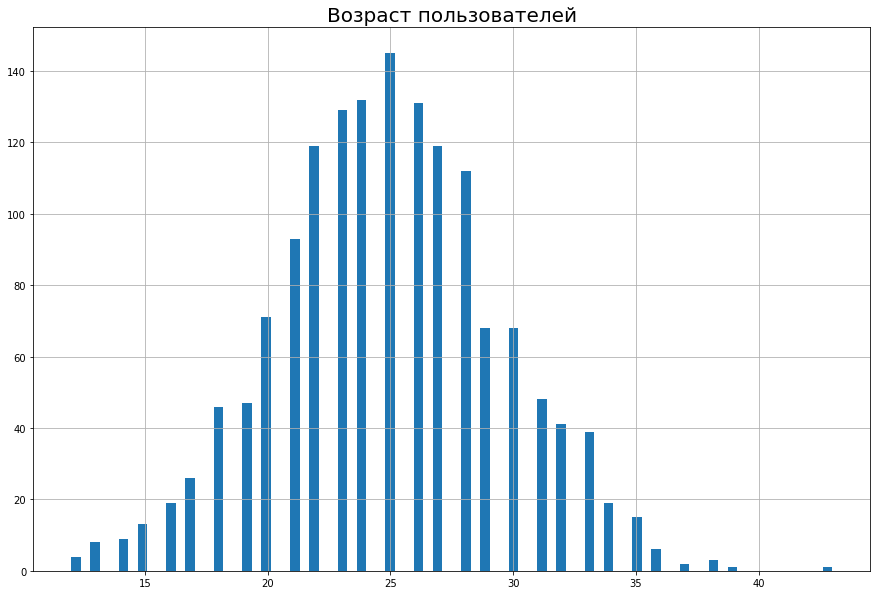

In [16]:
users['age'].hist(bins=80, figsize=(15, 10))
print(users['age'].describe())
plt.title('Возраст пользователей', fontsize=20)

##### Расстояние поездки

Заметно две группы поездок - короткие (до 1500 м), их сравнительно немного, и более длительные (длиннее 1500м). Из-за неоднородной структуры лучше смотреть на медиану - в среднем длина поездки составляет 3133м. Поездок длинне 6000м очень мало. Также можно увидеть совсем короткие поездки - длиной около метра. Скорее всего, поездка не состоялась, но был зафиксирован старт, и, если пользователь без подписки, с него взяли деньги за старт.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


Text(0.5, 1.0, 'Расстояние поездки')

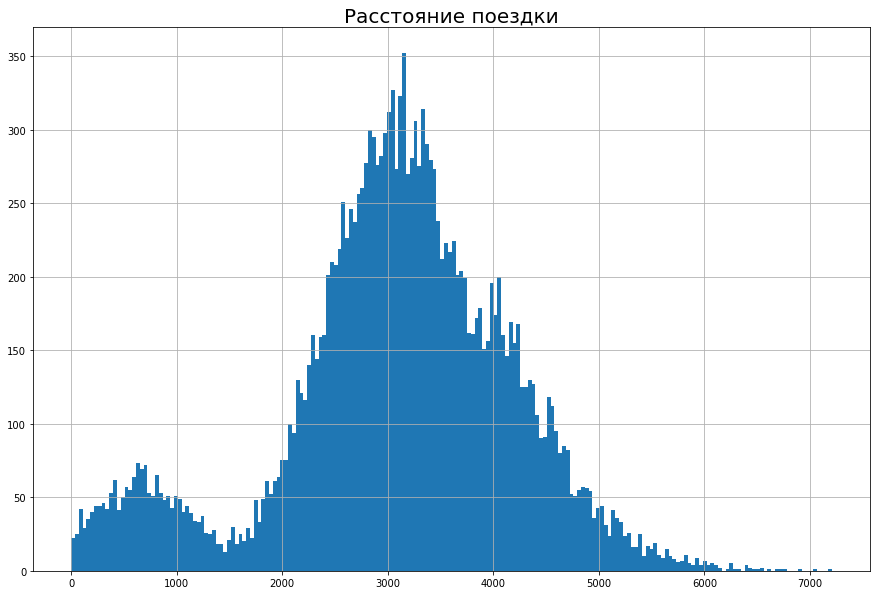

In [17]:
rides['distance'].hist(bins=200, figsize=(15, 10))
print(rides['distance'].describe())
plt.title('Расстояние поездки', fontsize=20)

##### Продолжительность поездок

Средняя длительность поездки - 17 минут. Основная часть поездок укладывается в интервал от 13.5 до 22 минут. Виден пик длительности около нуля - скорее всего, поездка не состоялась, была завершена сразу после начала по разным причинам (это подтверждает график длинны поездки, там есть длина, близкая к нулю). Зато мы видим некоторое количество коротких поездок - дольше 2-х минут, с возрастанием минут количество поездок возрастает.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


Text(0.5, 1.0, 'Продолжительность поездок')

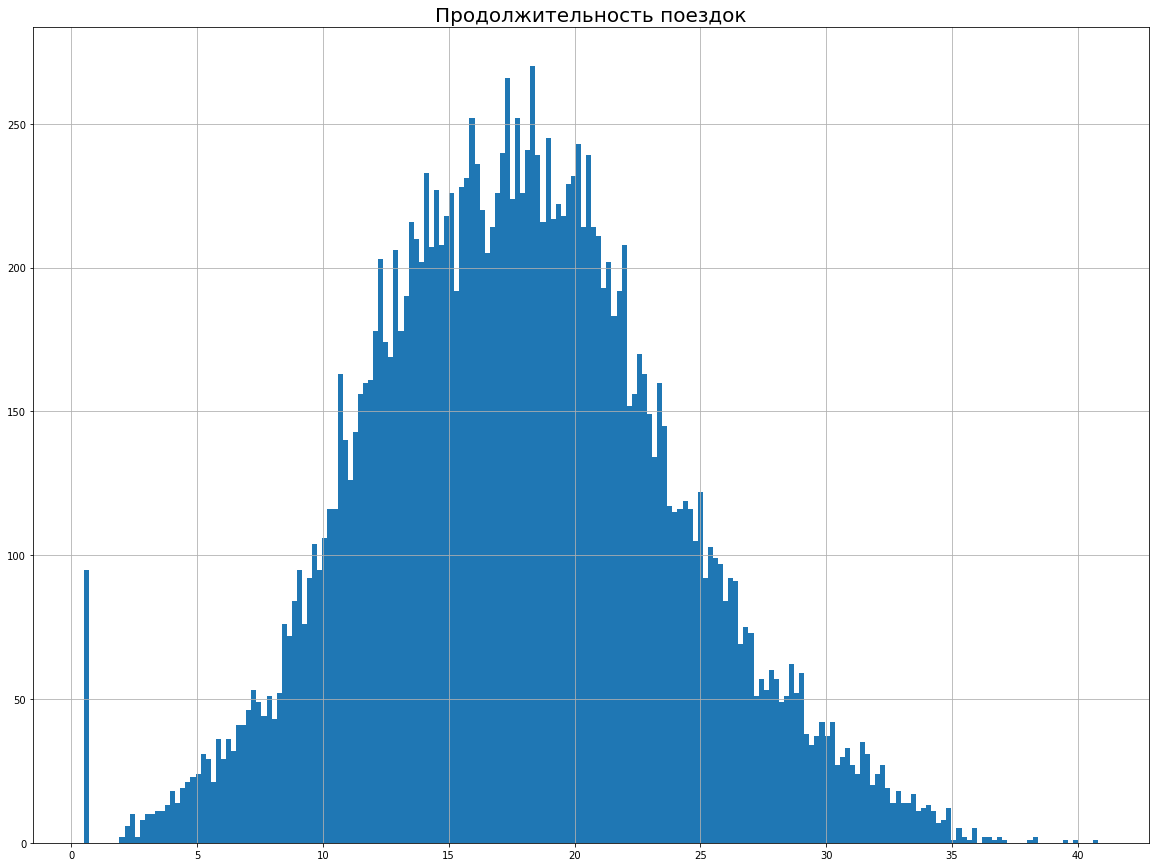

In [18]:
rides['duration'].hist(bins=200, figsize=(20, 15))
print(rides['duration'].describe())
plt.title('Продолжительность поездок', fontsize=20)

##### Вывод

Были рассмотрены основные показатели исследуемой базы данных. Мы выяснили, что данные о пользователях арендой самокатов касаются 2021 года, нескольких городов России.
Аномальных выбросов в данных не обнаружено, поэтому дополнительной обработки таких значений не было.
Вопросы возникают насчет возраста пользователей сервисом - есть данные о пользователях младше 18 лет, но эти данные также не будем трогать, потому что неизвестны правила пользования сервисом.
Были замечены очень короткие заезды - по длительности и расстоянию они близки к нулю. Они также не были удалены, так так плата за такие заезды может списываться и они могут влиять на конечный результат дальнейших расчетов.

#### Шаг 4. Объединение данных

##### Общий датафрейм

Объединим три базы данных в одну.

In [19]:
#Создадим новый датафрейм. Сначала присоединим к базе данных с поездками базу данных с пользователями
data = rides.merge(users, on='user_id')

#Потом к получившейся базе присоединим данные о подписках
data = data.merge(subscriptions, on='subscription_type')
data.head(15)

,user_id,distance,duration,date,date_month,date_year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,2021,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,2021,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,2021,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,2021,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,2021,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,2021,Кира,22,Тюмень,ultra,6,0,199


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   date_month         18068 non-null  int64         
 5   date_year          18068 non-null  int64         
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   subscription_type  18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(3)
memory 

Объединить базы получилось, были найдены известные данные для каждого пользователя, пропусков в итоговой таблице нет. Размер полученной базы данных равен размеру базы о поездках (18068 наблюдений). Также получилось верное количество столбцов - 11 переменных трех исходных таблиц и 2 переменных с месяцем и годом, которые создали в базе данных с поездками, всего 13.

##### Пользователи с подписками / без подписок

На основе общей базы данных создадим две новые. Первая будет включать только пользователей без подписки, вторая - только пользователей с подпиской Ultra. 

In [21]:
#Пользователи без подписки:
data_free = data.query('subscription_type == "free"')

#Пользователи с подпиской:
data_ultra = data.query('subscription_type == "ultra"')

##### Расстояние и время поездок для пользователей разных категорий

Сравним распределение расстояния поездок среди пользователей бесплатной (синий график) и платной (оранжевый график) версии подписки.
У пользователей бесплатной подпиской можно увидеть два пика наиболее популярного расстояния поездок - около 2500м и 3500м, тогда как у пользователей платной подписки один ярко выраженный пик - чуть больше 3000м.
Также есть различия в коротких заездах. У пользователей подписки Ultra их почти нет - минимальное расстояние поездки начинается примерно от 300м. Тогда как у того, кто не подписан на платный тариф, есть достаточно много "коротких" заездов, дистанция которых приближается к 0 метров.

Text(0.5, 1.0, 'Расстояние поездок разных категорий пользователей')

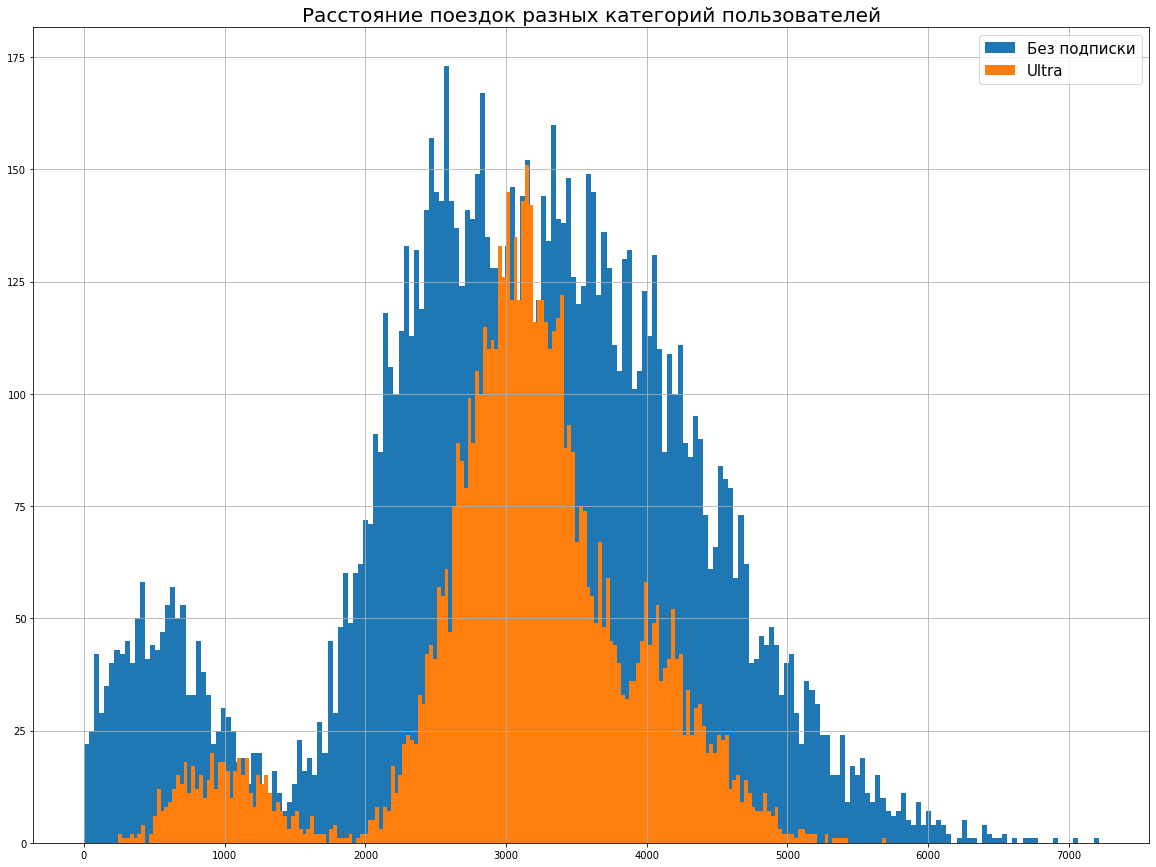

In [22]:
data_free['distance'].hist(bins=200, figsize=(20, 15))
data_ultra['distance'].hist(bins=200, figsize=(20, 15))
plt.legend(['Без подписки', 'Ultra'], fontsize=15)
plt.title('Расстояние поездок разных категорий пользователей', fontsize=20)

Рассмотрим подробнее время поездок пользователей разных категорий. Синий цвет графика - пользователи без подписки, оранжевый - с подпиской. Время поезлки у двух категорий пользователей очень похожи. Заметно лишь различие в очень коротких заездах - у пользователей без подписки очень большое количество заездов, близких к нулю. С подпиской такого пика не наблюдается.

Text(0.5, 1.0, 'Продолжительность поездок разных категорий пользователей')

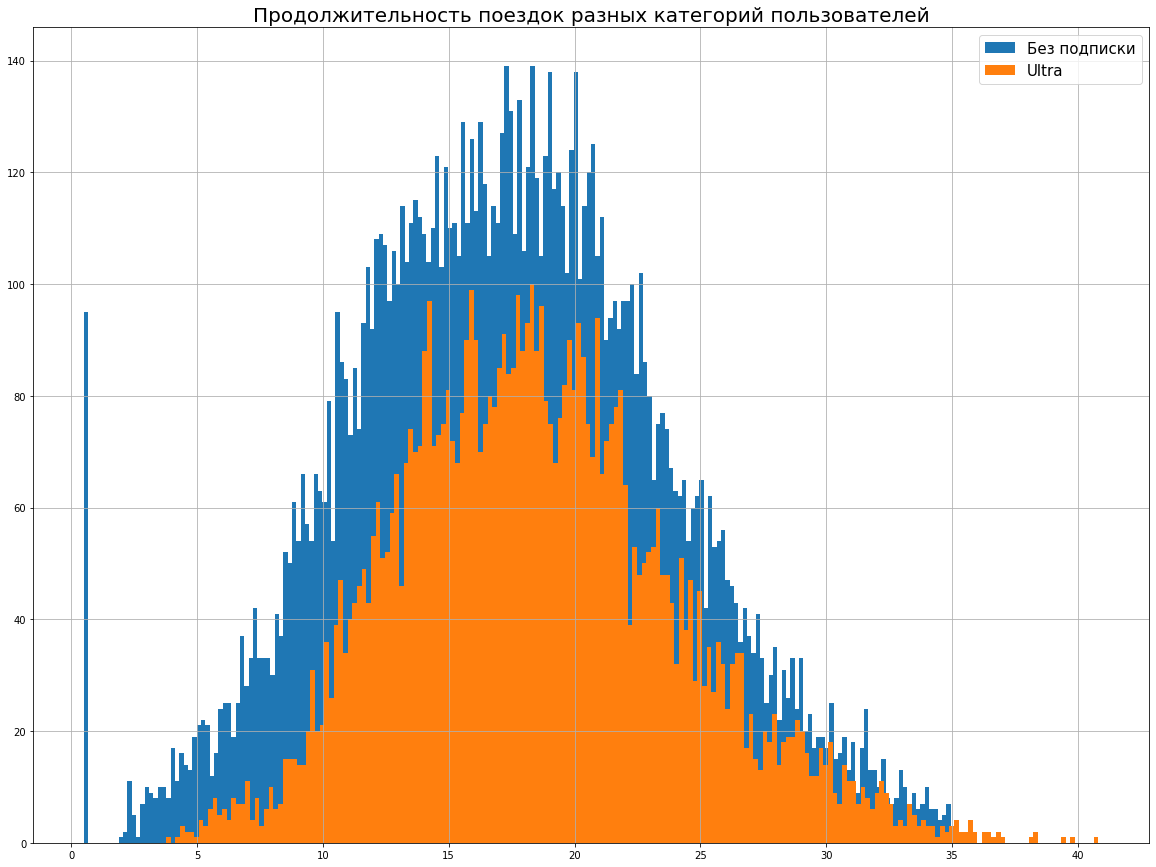

In [23]:
data_free['duration'].hist(bins=200, figsize=(20, 15))
data_ultra['duration'].hist(bins=200, figsize=(20, 15))
plt.legend(['Без подписки', 'Ultra'], fontsize=15)
plt.title('Продолжительность поездок разных категорий пользователей', fontsize=20)

#### Шаг 5. Подсчёт выручки

Посчитаем выручку, которую принес каждый пользователь аренды самокатов за каждый месяц.
Добавим в общий датафрейм столбец, в котором округлим длительность каждой поездки в большую сторону (до целых минут).

In [24]:
data['duration_round'] = np.ceil(data['duration'])

Сгруппируем данные по каждому пользователю и месяцу, сохраним в новую таблицу:

In [25]:
data_aggr = data.groupby(by=['user_id', 'date_month']) \
    .agg({'distance': 'sum', 'user_id': 'count', 'duration_round': 'sum', \
          'duration': 'first', 'date': 'first', 'date_year': 'first', 'name': 'first', \
          'age': 'first', 'city': 'first', 'subscription_type': 'first', 'minute_price': 'first', \
          'start_ride_price': 'first', 'subscription_fee': 'first'})
data_aggr.columns = ['distance_total', 'ride_total', 'duration_round_total', 'duration', 'date', 'date_year', 'name', 'age', 'city', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']
data_aggr = data_aggr.reset_index()
data_aggr.head()

,user_id,date_month,distance_total,ride_total,duration_round_total,duration,date,date_year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,25.599769,2021-01-01,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,4,754.159807,1,7.0,6.232113,2021-04-20,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,8,6723.470560,2,46.0,18.511000,2021-08-11,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,10,5809.911100,2,32.0,16.650138,2021-10-09,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,11,7003.499363,3,56.0,23.117468,2021-11-06,2021,Кира,22,Тюмень,ultra,6,0,199


В полученной таблице остались "старые" столбцы с нерелевантными данными, потому что мы выбрали только первые значения в них. Это столбцы duration и date, удалим их.

In [26]:
data_aggr = data_aggr.loc[:, ['user_id', 'date_month', 'distance_total', 'ride_total', 'duration_round_total', 'date_year', 'name', 'age', 'city', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
data_aggr.head()

,user_id,date_month,distance_total,ride_total,duration_round_total,date_year,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,2021,Кира,22,Тюмень,ultra,6,0,199
1,1,4,754.159807,1,7.0,2021,Кира,22,Тюмень,ultra,6,0,199
2,1,8,6723.470560,2,46.0,2021,Кира,22,Тюмень,ultra,6,0,199
3,1,10,5809.911100,2,32.0,2021,Кира,22,Тюмень,ultra,6,0,199
4,1,11,7003.499363,3,56.0,2021,Кира,22,Тюмень,ultra,6,0,199


Добавим в таблицу новый столбец, где посчитаем выручку по каждому пользователю и месяцу.

In [27]:
data_aggr['income'] = data_aggr['start_ride_price'] * data_aggr['ride_total'] + data_aggr['minute_price'] * data_aggr['duration_round_total'] + data_aggr['subscription_fee']

#### Шаг 6. Проверка гипотез

В этом разделе сравним пользователей без подписки и с подпиской.

##### Время поездки

Важно понять, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки.
Сформулируем нулевую гипотезу Н0: "Среднее время поездки пользователей с подпиской равно среднему времени поездки пользователей без подписки".
Альтернативная гипотеза H1: "Среднее время поездки пользователей с подпиской больше, чем пользователей без подписки".

Уровень значимости возьмем на уровне 5%. Проведем ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше".
Используем для анализа базы данных с данными о поездках, пользователях и подписках, отдельные для пользователей с подпиской и без подписки.

In [28]:
alpha = 0.05
results_duration = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
print(f'p-value: {results_duration.pvalue}')

# проверяем p-value
if results_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Значение p-value очень мало, что дает основание отвергнуть нулевую гипотезу о том, что среднее время поездки для двух групп пользователей равно. Мы принимаем альтернативную гипотезу - среднее время поездки пользователей с подпиской больше, чем пользователей без подписки.

Посмотри, чему равно среднее время поездки:

In [29]:
print('Среднее время поездки пользователя с подпиской', round(data_ultra['duration'].mean(), 2))
print('Среднее время поездки пользователя без подписки', round(data_free['duration'].mean(), 2))

Среднее время поездки пользователя с подпиской 18.54
Среднее время поездки пользователя без подписки 17.39


Вывод: можно утверждать, что пользователи с подпиской тратят больше времени на поездки.

Посчитаем среднюю цену поездки для пользователей с подпиской и без.
С подпиской: 18.54 * 6 (цена одной минуты) + 0 (плата за старт) = 111.24 руб.
Без подписки: 17.39 * 8 (цена одной минуты) + 50 (плата за старт) = 189.2 руб.

На первый взгляд пользователи с подпиской платят в среднем меньше за поездку на 77.96 руб. (189.2 - 111.24). Но они еще вносят ежемесячную плату. Получается, что пользователь с подпиской будет "выгоднее" для компании, если будет совершать меньше трех поездок в месяц (199 руб. / 77.96 руб. = 2.55 (примерно равно)), чтобы нивелировать разницу в стоимости поездки по сравнению с пользователем, который за подписку не платит. Для более точных выводов нужно посмотреть на среднемесячную выручку этих двух групп пользователей.

##### Расстояние - пользователи с подпиской

Важно, чтобы расстояние одной поездки не превышало 3130 метров, это расстояние оптимально с точки зрения износа самоката. 
Проверим гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Уровень значимости возьмем также на уровне 5%. Проведем односторонний ttest, сформулируем гипотезы следующим образом:
Нулевая гипотеза Н0: "Среднее расстояние одной поездки пользователей с подпиской равно или меньше 3130 метров".
Альтернативная гипотеза H1: "Среднее расстояние одной поездки пользователей с подпиской больше 3130 метров".

Используем базу данных с информацией только о пользователях с подпиской.

In [30]:
distance_optimal = 3130

alpha = 0.05 # уровень статистической значимости

results_distance = st.ttest_1samp(
    data_ultra['distance'], 
    distance_optimal,
      alternative='greater')

print('p-значение:', results_distance.pvalue)

if (results_distance.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


In [31]:
#выведем среднее расстояние одной поездки пользователей с подпиской:
data_ultra['distance'].mean()

3115.4453880370247

Вывод: тест на заданном уровне значимости показал, что среднее расстояние одной поездки пользователей с подпиской равно или меньше 3130 м.

##### Выручка

Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем нулевую гипотезу Н0: "Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки".
Альтернативная гипотеза H1: "Средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки".

Уровень значимости возьмем на уровне 5%. Проведем ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше".
Используем для анализа сгруппированную по месяцам и пользователям базу данных.

In [32]:
alpha = 0.05
results_income = st.ttest_ind(data_aggr.query('subscription_type == "ultra"')['income'], data_aggr.query('subscription_type == "free"')['income'], alternative='greater')
print(f'p-value: {results_income.pvalue}')

# проверяем p-value
if results_income.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Принимаем альтернативную гипотезу - средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.
Сравним средние выручки:

In [33]:
print('Средняя помесячная выручка пользователей с подпиской', data_aggr.query('subscription_type == "ultra"')['income'].mean())
print('Средняя помесячная выручка пользователей без подписки', data_aggr.query('subscription_type == "free"')['income'].mean())

Средняя помесячная выручка пользователей с подпиской 362.7921906022502
Средняя помесячная выручка пользователей без подписки 328.6413651073845


Вывод: средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.

##### Техническая поддержка

Представим, что у нас есть данные для каждого пользователя о количестве обращений в техническую поддержку до обновления и после него. Чтобы проверить, снизилось ли кол-во обращений в техническую поддержку после обновления, нужно использовать метод scipy.stats.ttest_rel(). Он проверяет гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок.

#### Шаг 7. Распределения

##### Промокоды на один бесплатный месяц

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

Так как количество наблюдений велико (по крайней мере больше 1000), то аппроксимируем биномиальное распределение нормальным. Для вычисления общего количества разосланных промокодов (n) нужно, чтобы кумулятивная функция распределения (cdf) от 100 была равна примерно 0.05. Будем менять значение n, чтобы добиться такого результата. 

In [34]:
# задаём параметры биномиального распределения
n = 1168 #этот параметр меняем таким образом, чтобы получить при 100, близкое к 0.05
p = 0.1

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 100
result = distr.cdf(100)
print(result)

0.050650790692463


При 1168 разосланных промокодах на один бесплатный месяц подписки с вероятностью примерно 5% как минимум 100 клиентов продлят эту подписку.

##### Push-уведомления в мобильном приложении

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [35]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


При таких вводных условия рассылки push-уведомления (1 млн.уведомлений и 40% открывших уведомления клиентов) вероятность получить открытыми более 399,5 тыс. писем (или равное этому значению) составляет около 85% ((1-0.1537)*100%), что довольно высокий показатель.

#### Вывод

Были обработаны данные о пользовании сервисом аренды самокатов GoFast - соединены данные о пользователях, об их поездках и справочная информация о существующих тарифах. Данные проверены на дубликаты и пропущенные значения, измене тип данных на подходящий, добавлены новые столбцы с месяцем и годом поездок, посчитана помесяная выручка для каждого пользователя.

Больше всего пользователей аренды самокатов в Пятигорске, меньше всего - в Москве. Пользуются подпиской 46% всех пользователей. Средний возраст - 25 лет. Средняя длительность поездки - 17 минут. Основная часть поездок укладывается в интервал от 13.5 до 22 минут.

Можно сделать выводы о том, что две группы пользователей - с подпиской и без - различаются по следующим параметрам:

1. Пользователи с подпиской тратят больше времени на поездки (в среднем 18.54 минут против 17.39 у пользователей без подписки). Они платят в среднем меньше за поездку на 77.96 руб. (189.2 - 111.24), но еще вносят ежемесячную плату. Получается, что пользователь с подпиской будет "выгоднее" для компании, если будет совершать меньше трех поездок в месяц (199 руб. / 77.96 руб. = 2.55 (примерно равно)), чтобы нивелировать разницу в стоимости поездки по сравнению с пользователем, который за подписку не платит. Для более точных выводов нужно посмотреть на среднемесячную выручку этих двух групп пользователей.

2. Средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки (362.79 руб. против 328.64руб у пользователей без подписки)

Также было рассчитано средняя дальность поездки у пользователей с платной подпиской. Она меньше критического расстояния износа самоката, что очень хорошо. Значит, увеличивать кол-во пользователей с подпиской выгодно, так как они приносят большую выручку, нежели пользователи без подписки.

Чтобы увеличить количество пользователей, пользующихся подпиской, можно проводить промоакции и рассылки, например:

1. Провести акцию с раздачей промокодов на один бесплатный месяц подписки. По завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. При 1168 разосланных промокодах на один бесплатный месяц подписки с вероятностью примерно 5% как минимум 100 клиентов продлят эту подписку.

2. Рассылает клиентам push-уведомления в мобильном приложении. При следующих вводных условиях рассылки push-уведомления - 1 млн.уведомлений и 40% открывших уведомления клиентов - вероятность получить открытыми более 399,5 тыс. писем составляет около 85%.